In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from scipy import interpolate
from scipy.optimize import newton_krylov, broyden1, root
%matplotlib inline  

In [15]:
x = 3
z = 4
R = np.sqrt(x**2+z**2)
B = 6

In [16]:
#Check at t=R/B -> p=x/RB
p = complex(x/(R*B),0)
w = p.real
y = p.imag

In [5]:
#Check at t>R/B -> p=x/RB + eps
p = complex(x/(R*B),0.01)
w = p.real
y = p.imag

In [18]:
t1 = w*x + 1j*y*x + np.sqrt(B**-2 - w**2 - 2*1j*w*y + y**2)*z #works
t2 = np.sqrt(((w**2+2*1j*w*y-y**2)*R**4 - (z*R/B)**2)/(x**2-z**2)) #doesn't work
t3 = np.sqrt((p*R**4-(z*R/B)**2)/(x**2-z**2)) #REALLY doesn't work
t4 = p*x + np.sqrt(B**-2-p**2)*z #works
print "t1: ", t1
print "t2: ", t2
print "t3: ", t3
print "t4: ", t4

t1:  (0.833333333333+0j)
t2:  (0.833333333333-0j)
t3:  -2.70947778018j
t4:  (0.833333333333+0j)


In [7]:
#Take t=R/B + eps, find a valid p
t = R/B 
p = (x*t + 1j*z*np.sqrt(t**2-(R/B)**2))/R**2
print p
print t
w = p.real
y = p.imag

(0.1+0j)
0.833333333333


# Method 1

Eq. (6.50) gives p(t) for $t\geq \frac R \beta$. Just use that up to a max t value.

In [2]:
#Method 1: grid real t, find p values using (6.50)
def p_from_t(x, z, B, tmax):
    R = np.sqrt(x**2+z**2)
    t = np.linspace(R/B,tmax,1000)
    p = (x*t + 1j*z*np.sqrt(t**2-(R/B)**2))/R**2
    return p

comp time:  0.0557191371918 s


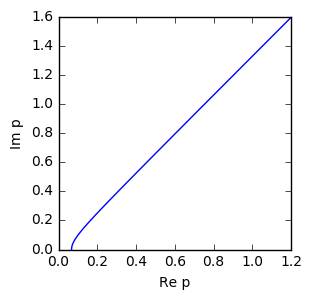

In [3]:
ts = time.time()
p1 = p_from_t(3,4,9,10)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p1.real,p1.imag)
tf = time.time()-ts
print "comp time: ", tf, "s"
ax.set_xlabel("Re p")
ax.set_ylabel("Im p")
plt.show()

# Method 2

Eq. (6.49) gives $t(p) = px + \eta |z|$ and we know $\eta = \sqrt{\beta^{-2}-p^2}$. Thus, $t = px+\sqrt{\beta^{-2}-p^2}|z|$.

We can take $p = w+i y$ to find t in terms of Re p and Im P coordinates, which we can then grid and search. We know $p=\frac{x}{R\beta}$ at $t=\frac R \beta$. Start there and examine a small grid in the p plane to find the direction of max increasing real t.

# plot the whole quadrant and compare p contours 

In [6]:
def t_from_p(x, zs, B, tmax):
    z = zs[0]
    h = zs[1]
    R = np.sqrt(x**2+(2*z-h)**2)
    print "p takeoff", x/(R*B[0])
    t = [0]
    p = [0*1j]
    
    def t_direct(p1):
        return p1*x + np.sqrt(B[0]**(-2)-p1**2)*z                     
    def t_reflect(p1):
        #calc t vector from p
        return p1*x+(z-h)*np.sqrt(1/B[0]**2-p1**2) + (z)*np.sqrt(1/B[0]**2-p1**2);
    
    while t[-1] < tmax:
#     step=0
#     while step < steps:
        w0 = p[-1].real
        y0 = p[-1].imag
        coords = []
        for n in range(1,20):
            for m in range(1,20):
                w = w0 + n*.00003
                y = y0 + m*.00003
                coords.append((w,y))
        tvals = [t_reflect(complex(*coord)) for coord in coords]
#         tnew = max([tv for tv in tvals if (abs(tv.imag)-y0)<.15])
#         t_ind = np.argmax([abs(tv) for tv in tvals])
        t_ind = np.argmax([tv.real for tv in tvals if (tv.imag-y0*.8)<.25])
#         t_ind = tvals.index(tnew)
        t.append(tvals[t_ind].real)
        p.append(complex(*coords[t_ind]))
#         step+=1
    
#     p0 = np.linspace(0,x/(R*B[0])-.00005,250)
#     t[:0] = t_reflect(p0)
#     p[:0] = p0
    
    return t, np.array(p)

In [8]:
z = 30
x = 70
h=8
R = np.sqrt(x**2+(2*z-h)**2)
beta0 = 2.5
beta = 3.5
ts = time.time()
t2, p2 = t_from_p(x,[z, h],[2.5, 3.5],55)
tf = time.time()-ts
print "comp time: ", tf, "s"
fig, ax = plt.subplots(1, 2, figsize = (6,3))
# axs = [[0, 1], [0, 2]]
ax[0].plot(p2.real,p2.imag)
ax[0].set_xlabel("Re p")
ax[0].set_ylabel("Im p")
ax[0].set_xlim([.25, .45])
js = np.arcsin(x/R)
y = np.linspace(0,.15,10)
x2 = y*np.tan(js)
ax[0].plot(x2,y)

#interpolate p(t) to regular t increment 
dt = .01
f=interpolate.interp1d(t2,p2);
xi=np.arange(t2[0],t2[-1],dt);
yi = f(xi)
dpdt=np.diff(yi)/0.01;
u=np.imag(dpdt*yi[:-1]**1.5/np.sqrt(1/2.5**2-yi[:-1]**2));
ax[1].plot(xi[:-1],u)
# ax[1].plot(np.diff(p2)/(np.diff(t2)+.0000001))
# ax[1].set_xlim([200, 300])

# Refection coefficient
rho0=2.0;
rho=2.7;
mu0=(beta0*1.e05)**2*rho0;
mu=(beta*1.e05)**2*rho;
Re=(mu0*np.sqrt(1/beta0**2-yi[:-1]**2)-mu*np.sqrt(1/beta**2-yi[:-1]**2)
  )/(mu0*np.sqrt(1/beta0**2-yi[:-1]**2)+mu*np.sqrt(1/beta**2-yi[:-1]**2));
u2=np.imag(Re*dpdt*yi[:-1]**1.5/np.sqrt(1/beta0**2-yi[:-1]**2));

ax[1].plot(xi[:-1],-1*u2)
ax[1].set_xlim([25, 50])

plt.show()

p takeoff 0.321097539182


ValueError: attempt to get argmax of an empty sequence

In [48]:
R/beta0

45.084808971537186

# Try a non-linear solver approach for consistent steps in t

In [58]:
#Define t function of p to equal zero for solver
x = 3
z = 6
B = 9
R = np.sqrt(x**2+z**2)
stop = 1
times = np.linspace(0,stop,stop/0.001)
def tf_reals(p1):
    p = np.array([complex(*pair) for pair in p1])
    zrs = p*x + np.sqrt(B**-2-p**2)*z - times
    return [[p2.real,p2.imag] for p2 in zrs]
x0 = np.zeros((len(times),2), float)
sol = broyden1(tf_reals,x0)

OverflowError: (34, 'Numerical result out of range')

In [59]:
sol

array([[ -9.93807912e-02,   1.33700662e-08],
       [ -9.82520233e-02,   4.89971012e-08],
       [ -9.70741162e-02,  -5.52721718e-08],
       [ -9.58470080e-02,  -6.82932502e-08]])

In [50]:
p1 = x0
p = np.array([complex(*pair) for pair in p1])
p*x + np.sqrt(B**-2-p**2)*z - times

array([ 0.66666667+0.j,  0.65010320+0.j,  0.63353973+0.j,  0.61697627+0.j])

# Set steps in T and Im(p), then maybe the solver can work 

In [17]:
x,z,B = (3,6,9)
# def t_Imp_steps(x,z,B):
R = np.sqrt(x**2+z**2)
print R/B
t = [R/B]
p = [x/(R*B)+0*1j]

ip = p[-1].imag
tn = t[-1]
#Define a residual function in only ip
def t_func(rp):
    p1 = complex(rp,ip)
    return p1*x + np.sqrt(B**-2-p1**2)*z - tn
print t_func(p[-1].real).real

#Step in im(p)
ip += .01
tn += .01
relp = fsolve(t_func, p[-1].real)
print t_func(relp)

0.7453559925
0.0
(-0.0062265663576-0.00037546832658j)


In [1]:
from scipy.optimize import fsolve
import math

def equations(p):
    x, y = p
    return (x+y**2-4, math.exp(x) + x*y - 3)

x, y =  fsolve(equations, (1, 1))

print equations((x, y))

(4.4508396968012676e-11, -1.0512035686360832e-11)
